In [74]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [73]:
# Create Tensors to hold input and outputs.

#第一组参数
# beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,-8]),np.zeros(90))
# beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,4]),np.zeros(90))
# beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,6]),np.zeros(90))

#第二组参数
beta_1=np.append(np.array([4,4,-8,-4,6,-4,8,4,-6,-8]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,2,-4,-2,-3,4]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,3,-6,-3,4.5,6]),np.zeros(90))

beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0
prior=[11,12,13,14,15]

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [30]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


In [31]:
sigmoid(x1@beta_1).squeeze().cov()
sigmoid(x2@beta_2).squeeze().cov()
sigmoid(x3@beta_3).squeeze().cov()

tensor(0.2293, dtype=torch.float64)

tensor(0.1916, dtype=torch.float64)

tensor(0.2171, dtype=torch.float64)

In [32]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [33]:
################## first step##################

# choose lambda1,lambda2 by ray tune

prior=[11,12,13,14,15]
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2,lr,ga= config["lambda1"], config["lambda2"],config["lr"],config["ga"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=2)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params,
                                           model_2_all_linear2_params,model_2_all_linear3_params,
                                           model_3_all_linear2_params,model_3_all_linear3_params),0)
            
            non_prior=np.setdiff1d([i for i in range(all_linear1_params.shape[1])],prior)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear23_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lr":tune.choice([0.6,0.7,0.8]),
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
        "ga":tune.choice([0.3,0.4,0.5])
    }
    result = tune.run(
        train_model,  
        config=config,
        num_samples=96)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,ga,lambda1,lambda2,lr,iter,total time (s),my_test_BCE_loss
train_model_9879a_00000,TERMINATED,10.224.0.12:3738,0.3,0.05,0.001,0.8,1,14.408,1.99454
train_model_9879a_00001,TERMINATED,10.224.0.12:4170,0.4,0.03,0.002,0.8,1,13.5852,1.92819
train_model_9879a_00002,TERMINATED,10.224.0.12:4172,0.3,0.05,0.002,0.8,1,13.3514,1.85443
train_model_9879a_00003,TERMINATED,10.224.0.12:4178,0.4,0.05,0.003,0.8,1,13.2678,1.75524
train_model_9879a_00004,TERMINATED,10.224.0.12:4174,0.4,0.03,0.001,0.8,1,13.0224,2.01975
train_model_9879a_00005,TERMINATED,10.224.0.12:4175,0.3,0.03,0.003,0.6,1,13.2642,1.88629
train_model_9879a_00006,TERMINATED,10.224.0.12:4176,0.5,0.03,0.001,0.7,1,13.1928,2.11182
train_model_9879a_00007,TERMINATED,10.224.0.12:4179,0.3,0.05,0.002,0.8,1,13.6926,1.85443
train_model_9879a_00008,TERMINATED,10.224.0.12:4181,0.3,0.04,0.001,0.7,1,13.3418,2.03637
train_model_9879a_00009,TERMINATED,10.224.0.12:4183,0.3,0.05,0.001,0.6,1,13.4299,1.9701


Result for train_model_9879a_00000:
  date: 2022-11-13_15-56-09
  done: false
  experiment_id: 6326c709403d4cb2b09fee92754d526f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.9945375204086304
  node_ip: 10.224.0.12
  pid: 3738
  time_since_restore: 14.407974004745483
  time_this_iter_s: 14.407974004745483
  time_total_s: 14.407974004745483
  timestamp: 1668326169
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9879a_00000
  warmup_time: 0.0037217140197753906
  
Result for train_model_9879a_00000:
  date: 2022-11-13_15-56-09
  done: true
  experiment_id: 6326c709403d4cb2b09fee92754d526f
  experiment_tag: 0_ga=0.3000,lambda1=0.0500,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.9945375204086304
  node_ip: 10.224.0.12
  pid: 3738
  time_since_restore: 14.407974004745483
  time_this_iter_s: 14.407974004745483
  time_total_s: 14.407974004745483
  timestamp: 1668326169
  timest

Result for train_model_9879a_00016:
  date: 2022-11-13_15-56-12
  done: true
  experiment_id: 5173a341dc8c481ea27f4d8d0e0bc888
  experiment_tag: 16_ga=0.5000,lambda1=0.0300,lambda2=0.0010,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.1118210315704347
  node_ip: 10.224.0.12
  pid: 4194
  time_since_restore: 13.33443832397461
  time_this_iter_s: 13.33443832397461
  time_total_s: 13.33443832397461
  timestamp: 1668326172
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9879a_00016
  warmup_time: 0.005589008331298828
  
Result for train_model_9879a_00011:
  date: 2022-11-13_15-56-12
  done: true
  experiment_id: 3a5132980b2d45ea81e60989fc8bae5c
  experiment_tag: 11_ga=0.5000,lambda1=0.0500,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.0457136154174806
  node_ip: 10.224.0.12
  pid: 4185
  time_since_restore: 13.248673915863037
  time_this_iter_s: 13.248673915863037


Result for train_model_9879a_00025:
  date: 2022-11-13_15-56-12
  done: true
  experiment_id: d93f89508dd747daaff7bcc378d507c0
  experiment_tag: 25_ga=0.5000,lambda1=0.0500,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.0457136154174806
  node_ip: 10.224.0.12
  pid: 4212
  time_since_restore: 13.304895877838135
  time_this_iter_s: 13.304895877838135
  time_total_s: 13.304895877838135
  timestamp: 1668326172
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9879a_00025
  warmup_time: 0.004716396331787109
  
Result for train_model_9879a_00024:
  date: 2022-11-13_15-56-12
  done: true
  experiment_id: 22a985f5c97d46139a4f5e75180a2251
  experiment_tag: 24_ga=0.3000,lambda1=0.0500,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.9701011180877686
  node_ip: 10.224.0.12
  pid: 4210
  time_since_restore: 13.475603818893433
  time_this_iter_s: 13.4756038188934

Result for train_model_9879a_00032:
  date: 2022-11-13_15-56-22
  done: false
  experiment_id: 6326c709403d4cb2b09fee92754d526f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.0274827003479006
  node_ip: 10.224.0.12
  pid: 3738
  time_since_restore: 12.42735505104065
  time_this_iter_s: 12.42735505104065
  time_total_s: 12.42735505104065
  timestamp: 1668326182
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9879a_00032
  warmup_time: 0.0037217140197753906
  
Result for train_model_9879a_00032:
  date: 2022-11-13_15-56-22
  done: true
  experiment_id: 6326c709403d4cb2b09fee92754d526f
  experiment_tag: 32_ga=0.5000,lambda1=0.0400,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.0274827003479006
  node_ip: 10.224.0.12
  pid: 3738
  time_since_restore: 12.42735505104065
  time_this_iter_s: 12.42735505104065
  time_total_s: 12.42735505104065
  timestamp: 1668326182
  timesteps_s

Result for train_model_9879a_00041:
  date: 2022-11-13_15-56-24
  done: true
  experiment_id: 6a3ea7ceff6740d7b754cc77c72d7f29
  experiment_tag: 41_ga=0.4000,lambda1=0.0400,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.9981443881988525
  node_ip: 10.224.0.12
  pid: 4198
  time_since_restore: 12.562711477279663
  time_this_iter_s: 12.562711477279663
  time_total_s: 12.562711477279663
  timestamp: 1668326184
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9879a_00041
  warmup_time: 0.007901668548583984
  
Result for train_model_9879a_00039:
  date: 2022-11-13_15-56-24
  done: false
  experiment_id: c3283915b04343a7b956390c3cfa88fb
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.949538564682007
  node_ip: 10.224.0.12
  pid: 4175
  time_since_restore: 12.687104940414429
  time_this_iter_s: 12.687104940414429
  time_total_s: 12.687104940414429
  timestamp: 1668326184
  timeste

Result for train_model_9879a_00052:
  date: 2022-11-13_15-56-25
  done: true
  experiment_id: b1a847567d0c4044a335f3237947390b
  experiment_tag: 52_ga=0.4000,lambda1=0.0300,lambda2=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.0599563837051393
  node_ip: 10.224.0.12
  pid: 4214
  time_since_restore: 12.659393787384033
  time_this_iter_s: 12.659393787384033
  time_total_s: 12.659393787384033
  timestamp: 1668326185
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9879a_00052
  warmup_time: 0.0074520111083984375
  
Result for train_model_9879a_00055:
  date: 2022-11-13_15-56-25
  done: false
  experiment_id: d93f89508dd747daaff7bcc378d507c0
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 2.0151776313781737
  node_ip: 10.224.0.12
  pid: 4212
  time_since_restore: 12.58228874206543
  time_this_iter_s: 12.58228874206543
  time_total_s: 12.58228874206543
  timestamp: 1668326185
  timestep

Result for train_model_9879a_00056:
  date: 2022-11-13_15-56-25
  done: false
  experiment_id: 22a985f5c97d46139a4f5e75180a2251
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.982979989051819
  node_ip: 10.224.0.12
  pid: 4210
  time_since_restore: 13.04922103881836
  time_this_iter_s: 13.04922103881836
  time_total_s: 13.04922103881836
  timestamp: 1668326185
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9879a_00056
  warmup_time: 0.005282402038574219
  
Result for train_model_9879a_00061:
  date: 2022-11-13_15-56-25
  done: false
  experiment_id: 5b7568aa06474b63a7c17a881117b63d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7552393913269042
  node_ip: 10.224.0.12
  pid: 4200
  time_since_restore: 12.830047369003296
  time_this_iter_s: 12.830047369003296
  time_total_s: 12.830047369003296
  timestamp: 1668326185
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9879a_00061
  war

Result for train_model_9879a_00068:
  date: 2022-11-13_15-56-36
  done: false
  experiment_id: edf2df9965ff4805b42ea43bcbded2d3
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8122905969619751
  node_ip: 10.224.0.12
  pid: 4176
  time_since_restore: 12.325921058654785
  time_this_iter_s: 12.325921058654785
  time_total_s: 12.325921058654785
  timestamp: 1668326196
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9879a_00068
  warmup_time: 0.0053708553314208984
  
Result for train_model_9879a_00068:
  date: 2022-11-13_15-56-36
  done: true
  experiment_id: edf2df9965ff4805b42ea43bcbded2d3
  experiment_tag: 68_ga=0.4000,lambda1=0.0400,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8122905969619751
  node_ip: 10.224.0.12
  pid: 4176
  time_since_restore: 12.325921058654785
  time_this_iter_s: 12.325921058654785
  time_total_s: 12.325921058654785
  timestamp: 1668326196
  times

Result for train_model_9879a_00082:
  date: 2022-11-13_15-56-37
  done: false
  experiment_id: b1a847567d0c4044a335f3237947390b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.843959426879883
  node_ip: 10.224.0.12
  pid: 4214
  time_since_restore: 12.26874589920044
  time_this_iter_s: 12.26874589920044
  time_total_s: 12.26874589920044
  timestamp: 1668326197
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9879a_00082
  warmup_time: 0.0074520111083984375
  
Result for train_model_9879a_00082:
  date: 2022-11-13_15-56-37
  done: true
  experiment_id: b1a847567d0c4044a335f3237947390b
  experiment_tag: 82_ga=0.5000,lambda1=0.0300,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.843959426879883
  node_ip: 10.224.0.12
  pid: 4214
  time_since_restore: 12.26874589920044
  time_this_iter_s: 12.26874589920044
  time_total_s: 12.26874589920044
  timestamp: 1668326197
  timesteps_sin

Result for train_model_9879a_00088:
  date: 2022-11-13_15-56-38
  done: false
  experiment_id: 3919db8751ef4caebceb162b4a4aae8e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8343419551849365
  node_ip: 10.224.0.12
  pid: 4179
  time_since_restore: 12.393384456634521
  time_this_iter_s: 12.393384456634521
  time_total_s: 12.393384456634521
  timestamp: 1668326198
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 9879a_00088
  warmup_time: 0.032561540603637695
  
Result for train_model_9879a_00088:
  date: 2022-11-13_15-56-38
  done: true
  experiment_id: 3919db8751ef4caebceb162b4a4aae8e
  experiment_tag: 88_ga=0.3000,lambda1=0.0400,lambda2=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8343419551849365
  node_ip: 10.224.0.12
  pid: 4179
  time_since_restore: 12.393384456634521
  time_this_iter_s: 12.393384456634521
  time_total_s: 12.393384456634521
  timestamp: 1668326198
  timest

2022-11-13 15:56:39,208	INFO tune.py:758 -- Total run time: 46.59 seconds (46.41 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
9879a_00000          1.994538         14.407974  True            None   
9879a_00001          1.928191         13.585184  True            None   
9879a_00002          1.854425         13.351425  True            None   
9879a_00003          1.755239         13.267847  True            None   
9879a_00004          2.019752         13.022438  True            None   
...                       ...               ...   ...             ...   
9879a_00091          1.886649         12.050901  True            None   
9879a_00092          1.798783         12.485765  True            None   
9879a_00093          1.994538         12.480709  True            None   
9879a_00094          1.823871         11.092645  True            None   
9879a_00095          1.790845         11.633158  True            N

In [34]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 1.7544147729873658


{'lr': 0.8, 'lambda1': 0.05, 'lambda2': 0.003, 'ga': 0.3}

In [35]:
################## second step##################

prior=[11,12,13,14,15]
# set hyperparamters
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
# lambda1,lambda2,lr=final_lambda["lambda1"],final_lambda["lambda2"],final_lambda["lr"]
lambda1,lambda2,lr,ga=final_lambda["lambda1"],final_lambda["lambda2"],final_lambda["lr"],final_lambda["ga"]
learning_rate=lr
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out


model_1=MLP(seed=1)
model_2=MLP(seed=2)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])

    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])

    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, 
                                     model_2_all_linear2_params,model_2_all_linear3_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params),0)
    
    non_prior=np.setdiff1d([i for i in range(all_linear1_params.shape[1])],prior)

    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))

        #     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)

    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))
    l2_regularization = lambda2 * torch.sum(all_linear23_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.3798, grad_fn=<AddBackward0>)

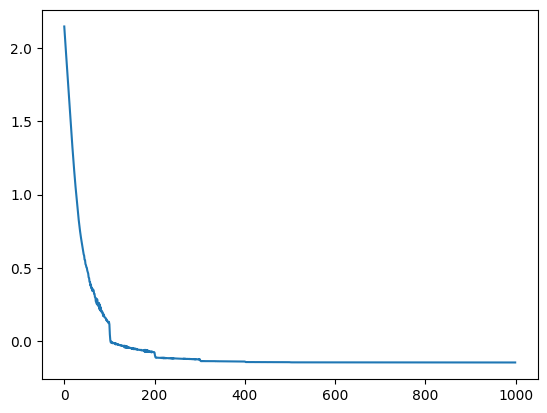

In [36]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [37]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-2.7441e-01, -1.1048e-06, -3.3950e-01, -1.5187e-02, -3.6857e-08,
         -3.7914e-01,  1.2990e-06, -2.5026e-06,  6.9208e-02,  3.4912e-01,
         -1.7472e-01, -4.4693e-01, -7.6112e-01,  1.4686e+00,  5.4688e-01,
          7.7055e-01,  5.6353e-08, -4.6406e-07, -1.9901e-07,  2.4265e-06,
         -1.1602e-06,  1.1646e-06,  2.7731e-06, -2.8171e-06,  3.0224e-06,
         -3.5629e-06, -4.1665e-06, -2.9290e-06,  2.9448e-06, -3.8333e-07,
          1.8484e-06,  7.7821e-07,  1.4923e-06, -3.3276e-06,  8.0355e-08,
         -2.0104e-06, -2.9043e-06,  2.7311e-07,  7.0004e-07,  1.4360e-07,
         -2.2954e-06, -5.2868e-07,  7.0817e-07,  8.0865e-07,  1.7470e-06,
          1.8173e-06,  1.8500e-01,  1.6573e-06, -7.3769e-07,  3.4779e-06,
         -1.1053e-07,  4.7155e-07,  2.8456e-06,  7.3637e-07,  2.5831e-06,
          5.0488e-06,  2.3646e-06, -6.4698e-07,  2.0399e-06,  3.2987e-06,
          8.3326e-07, -3.1896e-06, -2.4889e-01, -7.9146e-07, -8.3733e-07,
          6.2943e-07, -1.6404e-06, -2.

tensor([[-2.7441e-01, -1.1048e-06, -3.3950e-01, -1.5187e-02, -3.6857e-08,
         -3.7914e-01,  1.2990e-06, -2.5026e-06,  6.9208e-02,  3.4912e-01,
         -1.7472e-01, -4.4693e-01, -7.6112e-01,  1.4686e+00,  5.4688e-01,
          7.7055e-01,  5.6353e-08, -4.6406e-07, -1.9901e-07,  2.4265e-06,
         -1.1602e-06,  1.1646e-06,  2.7731e-06, -2.8171e-06,  3.0224e-06,
         -3.5629e-06, -4.1665e-06, -2.9290e-06,  2.9448e-06, -3.8333e-07,
          1.8484e-06,  7.7821e-07,  1.4923e-06, -3.3276e-06,  8.0355e-08,
         -2.0104e-06, -2.9043e-06,  2.7311e-07,  7.0004e-07,  1.4360e-07,
         -2.2954e-06, -5.2868e-07,  7.0817e-07,  8.0865e-07,  1.7470e-06,
          1.8173e-06,  1.8500e-01,  1.6573e-06, -7.3769e-07,  3.4779e-06,
         -1.1053e-07,  4.7155e-07,  2.8456e-06,  7.3637e-07,  2.5831e-06,
          5.0488e-06,  2.3646e-06, -6.4698e-07,  2.0399e-06,  3.2987e-06,
          8.3326e-07, -3.1896e-06, -2.4889e-01, -7.9146e-07, -8.3733e-07,
          6.2943e-07, -1.6404e-06, -2.

tensor([[-3.2304e-01, -4.3689e-08, -4.3521e-01, -3.7666e-01,  1.8514e-08,
         -4.7976e-01,  7.6254e-07,  6.1162e-07, -2.3932e-01,  4.3033e-01,
         -7.8882e-02, -6.4239e-01, -4.6889e-01,  1.3574e+00,  4.7621e-01,
          8.3062e-01, -5.3138e-09,  1.1665e-07,  2.7616e-07, -1.0706e-07,
          3.2565e-07,  5.6947e-10,  6.8448e-07, -1.5037e-07, -9.4768e-08,
         -2.3738e-07, -1.0032e-08,  3.7124e-07,  2.1795e-07,  1.4677e-08,
         -1.2010e-06,  9.2413e-09,  1.5726e-06,  8.0531e-08,  3.8904e-07,
         -1.1690e-06,  2.0281e-08,  2.3721e-07, -2.0460e-07, -1.5109e-08,
          2.3067e-07,  5.0882e-08, -5.9145e-09, -7.4275e-09,  1.2756e-06,
         -4.4535e-07,  4.0396e-01,  1.1738e-07,  2.7952e-08, -8.7827e-07,
         -1.2635e-08, -5.7678e-08,  6.0159e-09,  5.6626e-09,  7.4089e-08,
          3.4100e-08, -2.1813e-08,  4.6932e-07,  7.5471e-08,  1.0020e-06,
          2.4594e-07,  5.4514e-08, -1.7553e-01, -1.8373e-08,  1.2920e-07,
         -6.3069e-08, -1.7185e-08, -8.

In [38]:
################## Y_prior##################

y_prior_1= (model_1(train_x1)[0]).detach().squeeze()

y_prior_2= (model_2(train_x2)[0]).detach().squeeze()

y_prior_3= (model_3(train_x3)[0]).detach().squeeze()

BCE_loss_1 = loss_fn(y_prior_1,train_y1)
BCE_loss_2 = loss_fn(y_prior_2, train_y2)
BCE_loss_3 = loss_fn(y_prior_3, train_y3)
BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
BCE_loss
BCE_loss_1
BCE_loss_2
BCE_loss_3

tensor(0.3798)

tensor(0.1950)

tensor(0.0130)

tensor(0.1718)

In [39]:
y_p_1= (model_1(train_x1)[0]>0.5).clone().int()
t_p_1= train_y1.reshape(-1,1).int()

y_p_2= (model_2(train_x2)[0]>0.5).clone().int()
t_p_2= train_y2.reshape(-1,1).int()

y_p_3= (model_3(train_x3)[0]>0.5).clone().int()
t_p_3= train_y3.reshape(-1,1).int()

confusion_matrix(t_p_1,y_p_1)
confusion_matrix(t_p_2,y_p_2)
confusion_matrix(t_p_3,y_p_3)

array([[79,  5],
       [ 4, 72]])

array([[79,  0],
       [ 0, 81]])

array([[71,  4],
       [ 3, 82]])

In [40]:
################## third step##################
##为缩短运行时间，将lambda2固定##

#no prior
prior=0
# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3



# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)
    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)
    
    
    lambda1,lambda2,eta,lr= config["lambda1"], config["lambda2"],config["eta"],config["lr"]
    inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
    targets_1=(1-eta)*train_y1+eta*y_prior_1
    targets_2=(1-eta)*train_y2+eta*y_prior_2
    targets_3=(1-eta)*train_y3+eta*y_prior_3
    
    
    sum_tGM=0
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
       
        
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
# #         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
# #         test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
# #         test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))

#         test_BCE_loss_1 = loss_fn(test_out_1, train_y1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, train_y2[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, train_y3[idx_test].reshape(-1,1))
        
#         test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
#         sum_test_BCE_loss+=test_BCE_loss.item()

#     #print("loss: ",)
#     tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)

        test_prediction_1= (model_1(train_x1[idx_test])[0]>0.5).clone().int()
        test_target_1= train_y1[idx_test].reshape(-1,1).int()

        test_prediction_2= (model_2(train_x2[idx_test])[0]>0.5).clone().int()
        test_target_2= train_y2[idx_test].reshape(-1,1).int()

        test_prediction_3= (model_3(train_x3[idx_test])[0]>0.5).clone().int()
        test_target_3= train_y3[idx_test].reshape(-1,1).int()

        test_prediction=np.append(test_prediction_1,test_prediction_2)
        test_prediction=np.append(test_prediction,test_prediction_3)
        test_prediction=test_prediction.tolist()

        test_target=np.append(test_target_1,test_target_2)
        test_target=np.append(test_target,test_target_3)
        test_target=test_target.tolist()

        final_matrix=confusion_matrix(test_target,test_prediction)
        tTPR=recall_score(test_target,test_target)#TPR
        tTNR=final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
        tGM=math.sqrt(tTPR*tTNR)

        sum_tGM+=tGM

    tune.report(my_test_sum_tGM=sum_tGM/split_num)
     
        
if __name__ == '__main__':
#     inputs_1,targets_1 = train_x1,train_y1
#     inputs_2,targets_2 = train_x2,train_y2
#     inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
#     config={
#         "lambda1": tune.choice([0.01,0.02,0.03,0.04,0.05]),
#         "lambda2": tune.choice([0.001,0.002,0.003]),
#         "eta": tune.choice([0.06,0.09,0.1,0.12,0.15,0.17,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
#     }
    config={
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.002]),
         "eta": tune.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]),
         "lr":tune.choice([0.6,0.7,0.8])
                            }
#         "eta": tune.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])



    result = tune.run(
        train_model,  
        config=config,
        num_samples=160)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,eta,lambda1,lambda2,lr,iter,total time (s),my_test_sum_tGM
train_model_d0564_00000,TERMINATED,10.224.0.12:5788,0.1,0.05,0.002,0.6,1,14.8433,0.881829
train_model_d0564_00001,TERMINATED,10.224.0.12:6214,0.4,0.03,0.002,0.7,1,15.219,0.853703
train_model_d0564_00002,TERMINATED,10.224.0.12:6216,0.2,0.04,0.002,0.7,1,14.972,0.870018
train_model_d0564_00003,TERMINATED,10.224.0.12:6218,0.1,0.04,0.002,0.7,1,15.1173,0.844897
train_model_d0564_00004,TERMINATED,10.224.0.12:6220,0.5,0.04,0.002,0.8,1,14.8694,0.88664
train_model_d0564_00005,TERMINATED,10.224.0.12:6222,0.7,0.05,0.002,0.7,1,15.1766,0.882658
train_model_d0564_00006,TERMINATED,10.224.0.12:6224,0.5,0.03,0.002,0.8,1,15.0324,0.867895
train_model_d0564_00007,TERMINATED,10.224.0.12:6226,0.7,0.05,0.002,0.7,1,15.1976,0.882658
train_model_d0564_00008,TERMINATED,10.224.0.12:6228,0.5,0.03,0.002,0.7,1,15.0334,0.852617
train_model_d0564_00009,TERMINATED,10.224.0.12:6230,0.6,0.03,0.002,0.8,1,15.2307,0.873327


Result for train_model_d0564_00000:
  date: 2022-11-13_15-57-43
  done: false
  experiment_id: 3fdd2c9577da4479928f005d1dcb4668
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8818285613281682
  node_ip: 10.224.0.12
  pid: 5788
  time_since_restore: 14.843324661254883
  time_this_iter_s: 14.843324661254883
  time_total_s: 14.843324661254883
  timestamp: 1668326263
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00000
  warmup_time: 0.0034983158111572266
  
Result for train_model_d0564_00000:
  date: 2022-11-13_15-57-43
  done: true
  experiment_id: 3fdd2c9577da4479928f005d1dcb4668
  experiment_tag: 0_eta=0.1000,lambda1=0.0500,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8818285613281682
  node_ip: 10.224.0.12
  pid: 5788
  time_since_restore: 14.843324661254883
  time_this_iter_s: 14.843324661254883
  time_total_s: 14.843324661254883
  timestamp: 1668326263
  timeste

Result for train_model_d0564_00015:
  date: 2022-11-13_15-57-47
  done: false
  experiment_id: 1f9df9a62f864e468fcdc7d1e53c754e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8448971046594018
  node_ip: 10.224.0.12
  pid: 6242
  time_since_restore: 15.036479711532593
  time_this_iter_s: 15.036479711532593
  time_total_s: 15.036479711532593
  timestamp: 1668326267
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00015
  warmup_time: 0.005426883697509766
  
Result for train_model_d0564_00010:
  date: 2022-11-13_15-57-47
  done: true
  experiment_id: a0b7c8558d72403d96591322ede4f5a7
  experiment_tag: 10_eta=0.2000,lambda1=0.0400,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.87001750240675
  node_ip: 10.224.0.12
  pid: 6232
  time_since_restore: 14.824977159500122
  time_this_iter_s: 14.824977159500122
  time_total_s: 14.824977159500122
  timestamp: 1668326267
  timesteps

Result for train_model_d0564_00019:
  date: 2022-11-13_15-57-47
  done: true
  experiment_id: 86cf9326612141778be766505f314478
  experiment_tag: 19_eta=0.5000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8678954825429368
  node_ip: 10.224.0.12
  pid: 6250
  time_since_restore: 15.1817045211792
  time_this_iter_s: 15.1817045211792
  time_total_s: 15.1817045211792
  timestamp: 1668326267
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00019
  warmup_time: 0.004266977310180664
  
Result for train_model_d0564_00030:
  date: 2022-11-13_15-57-48
  done: false
  experiment_id: 2702aa04504c4a63a90397ec436e087e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.88483152509971
  node_ip: 10.224.0.12
  pid: 6272
  time_since_restore: 14.86058235168457
  time_this_iter_s: 14.86058235168457
  time_total_s: 14.86058235168457
  timestamp: 1668326268
  timesteps_since_re

Result for train_model_d0564_00027:
  date: 2022-11-13_15-57-49
  done: false
  experiment_id: f14f3364340443a396c2d236f5e028c3
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.885748946275687
  node_ip: 10.224.0.12
  pid: 6266
  time_since_restore: 17.182636737823486
  time_this_iter_s: 17.182636737823486
  time_total_s: 17.182636737823486
  timestamp: 1668326269
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00027
  warmup_time: 0.0031702518463134766
  
Result for train_model_d0564_00027:
  date: 2022-11-13_15-57-49
  done: true
  experiment_id: f14f3364340443a396c2d236f5e028c3
  experiment_tag: 27_eta=0.3000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.885748946275687
  node_ip: 10.224.0.12
  pid: 6266
  time_since_restore: 17.182636737823486
  time_this_iter_s: 17.182636737823486
  time_total_s: 17.182636737823486
  timestamp: 1668326269
  timestep

Result for train_model_d0564_00034:
  date: 2022-11-13_15-58-01
  done: false
  experiment_id: 812c182b051a4377ad493c4e637c13d1
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8791704785461855
  node_ip: 10.224.0.12
  pid: 6248
  time_since_restore: 14.273164987564087
  time_this_iter_s: 14.273164987564087
  time_total_s: 14.273164987564087
  timestamp: 1668326281
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00034
  warmup_time: 0.0072176456451416016
  
Result for train_model_d0564_00034:
  date: 2022-11-13_15-58-01
  done: true
  experiment_id: 812c182b051a4377ad493c4e637c13d1
  experiment_tag: 34_eta=0.6000,lambda1=0.0400,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8791704785461855
  node_ip: 10.224.0.12
  pid: 6248
  time_since_restore: 14.273164987564087
  time_this_iter_s: 14.273164987564087
  time_total_s: 14.273164987564087
  timestamp: 1668326281
  timest

Result for train_model_d0564_00041:
  date: 2022-11-13_15-58-02
  done: false
  experiment_id: 2287cdbdbde8425fb388b032084e1f0a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8404603952333443
  node_ip: 10.224.0.12
  pid: 6238
  time_since_restore: 14.385319709777832
  time_this_iter_s: 14.385319709777832
  time_total_s: 14.385319709777832
  timestamp: 1668326282
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00041
  warmup_time: 0.004449367523193359
  
Result for train_model_d0564_00041:
  date: 2022-11-13_15-58-02
  done: true
  experiment_id: 2287cdbdbde8425fb388b032084e1f0a
  experiment_tag: 41_eta=0.4000,lambda1=0.0300,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8404603952333443
  node_ip: 10.224.0.12
  pid: 6238
  time_since_restore: 14.385319709777832
  time_this_iter_s: 14.385319709777832
  time_total_s: 14.385319709777832
  timestamp: 1668326282
  timeste

Result for train_model_d0564_00042:
  date: 2022-11-13_15-58-03
  done: false
  experiment_id: a987407695174b94aa1d0e90a30ac1fb
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8531159065742717
  node_ip: 10.224.0.12
  pid: 6240
  time_since_restore: 15.368284702301025
  time_this_iter_s: 15.368284702301025
  time_total_s: 15.368284702301025
  timestamp: 1668326283
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00042
  warmup_time: 0.006163120269775391
  
Result for train_model_d0564_00042:
  date: 2022-11-13_15-58-03
  done: true
  experiment_id: a987407695174b94aa1d0e90a30ac1fb
  experiment_tag: 42_eta=0.6000,lambda1=0.0300,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8531159065742717
  node_ip: 10.224.0.12
  pid: 6240
  time_since_restore: 15.368284702301025
  time_this_iter_s: 15.368284702301025
  time_total_s: 15.368284702301025
  timestamp: 1668326283
  timeste

Result for train_model_d0564_00067:
  date: 2022-11-13_15-58-15
  done: true
  experiment_id: 1f9df9a62f864e468fcdc7d1e53c754e
  experiment_tag: 67_eta=0.7000,lambda1=0.0400,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8818461706297047
  node_ip: 10.224.0.12
  pid: 6242
  time_since_restore: 13.860889673233032
  time_this_iter_s: 13.860889673233032
  time_total_s: 13.860889673233032
  timestamp: 1668326295
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00067
  warmup_time: 0.005426883697509766
  
Result for train_model_d0564_00074:
  date: 2022-11-13_15-58-15
  done: false
  experiment_id: 337abdeffcd643fa96315fae1b8b6631
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.891518703248962
  node_ip: 10.224.0.12
  pid: 6228
  time_since_restore: 13.779792308807373
  time_this_iter_s: 13.779792308807373
  time_total_s: 13.779792308807373
  timestamp: 1668326295
  timestep

Result for train_model_d0564_00079:
  date: 2022-11-13_15-58-15
  done: true
  experiment_id: bb9998f0c9994826b62f1c5aa1a29a2e
  experiment_tag: 79_eta=0.3000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8558127954549797
  node_ip: 10.224.0.12
  pid: 6236
  time_since_restore: 13.994531393051147
  time_this_iter_s: 13.994531393051147
  time_total_s: 13.994531393051147
  timestamp: 1668326295
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00079
  warmup_time: 0.006890535354614258
  
Result for train_model_d0564_00080:
  date: 2022-11-13_15-58-15
  done: true
  experiment_id: bee5598bfeae4ec9831ae10b66530ac4
  experiment_tag: 80_eta=0.6000,lambda1=0.0400,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8870840358669574
  node_ip: 10.224.0.12
  pid: 6244
  time_since_restore: 13.978893280029297
  time_this_iter_s: 13.9788932800292

Result for train_model_d0564_00077:
  date: 2022-11-13_15-58-17
  done: false
  experiment_id: 49bb609b33284175bc06cd95055d7f1d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8531159065742717
  node_ip: 10.224.0.12
  pid: 6222
  time_since_restore: 15.180507898330688
  time_this_iter_s: 15.180507898330688
  time_total_s: 15.180507898330688
  timestamp: 1668326297
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00077
  warmup_time: 0.005284786224365234
  
Result for train_model_d0564_00077:
  date: 2022-11-13_15-58-17
  done: true
  experiment_id: 49bb609b33284175bc06cd95055d7f1d
  experiment_tag: 77_eta=0.6000,lambda1=0.0300,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8531159065742717
  node_ip: 10.224.0.12
  pid: 6222
  time_since_restore: 15.180507898330688
  time_this_iter_s: 15.180507898330688
  time_total_s: 15.180507898330688
  timestamp: 1668326297
  timeste

Result for train_model_d0564_00094:
  date: 2022-11-13_15-58-18
  done: false
  experiment_id: f14f3364340443a396c2d236f5e028c3
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8441906378181635
  node_ip: 10.224.0.12
  pid: 6266
  time_since_restore: 14.176227331161499
  time_this_iter_s: 14.176227331161499
  time_total_s: 14.176227331161499
  timestamp: 1668326298
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00094
  warmup_time: 0.0031702518463134766
  
Result for train_model_d0564_00094:
  date: 2022-11-13_15-58-18
  done: true
  experiment_id: f14f3364340443a396c2d236f5e028c3
  experiment_tag: 94_eta=0.1000,lambda1=0.0300,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8441906378181635
  node_ip: 10.224.0.12
  pid: 6266
  time_since_restore: 14.176227331161499
  time_this_iter_s: 14.176227331161499
  time_total_s: 14.176227331161499
  timestamp: 1668326298
  timest

Result for train_model_d0564_00101:
  date: 2022-11-13_15-58-29
  done: false
  experiment_id: 337abdeffcd643fa96315fae1b8b6631
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8653637295649957
  node_ip: 10.224.0.12
  pid: 6228
  time_since_restore: 14.23220181465149
  time_this_iter_s: 14.23220181465149
  time_total_s: 14.23220181465149
  timestamp: 1668326309
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00101
  warmup_time: 0.004771232604980469
  
Result for train_model_d0564_00104:
  date: 2022-11-13_15-58-29
  done: false
  experiment_id: 5dae324fa10d47279e06076f2dcd23ae
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8777018706400399
  node_ip: 10.224.0.12
  pid: 6224
  time_since_restore: 13.962294340133667
  time_this_iter_s: 13.962294340133667
  time_total_s: 13.962294340133667
  timestamp: 1668326309
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00104
  warm

Result for train_model_d0564_00114:
  date: 2022-11-13_15-58-30
  done: false
  experiment_id: ed23188c98d04a7aa8dab1196134052a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8678310555314679
  node_ip: 10.224.0.12
  pid: 6234
  time_since_restore: 14.064193964004517
  time_this_iter_s: 14.064193964004517
  time_total_s: 14.064193964004517
  timestamp: 1668326310
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00114
  warmup_time: 0.004367828369140625
  
Result for train_model_d0564_00114:
  date: 2022-11-13_15-58-30
  done: true
  experiment_id: ed23188c98d04a7aa8dab1196134052a
  experiment_tag: 114_eta=0.9000,lambda1=0.0300,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8678310555314679
  node_ip: 10.224.0.12
  pid: 6234
  time_since_restore: 14.064193964004517
  time_this_iter_s: 14.064193964004517
  time_total_s: 14.064193964004517
  timestamp: 1668326310
  timest

Result for train_model_d0564_00122:
  date: 2022-11-13_15-58-32
  done: false
  experiment_id: da951bdee07742d1b41992545b9073ea
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8871970387972847
  node_ip: 10.224.0.12
  pid: 6226
  time_since_restore: 14.066045761108398
  time_this_iter_s: 14.066045761108398
  time_total_s: 14.066045761108398
  timestamp: 1668326312
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00122
  warmup_time: 0.005904674530029297
  
Result for train_model_d0564_00122:
  date: 2022-11-13_15-58-32
  done: true
  experiment_id: da951bdee07742d1b41992545b9073ea
  experiment_tag: 122_eta=0.8000,lambda1=0.0400,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8871970387972847
  node_ip: 10.224.0.12
  pid: 6226
  time_since_restore: 14.066045761108398
  time_this_iter_s: 14.066045761108398
  time_total_s: 14.066045761108398
  timestamp: 1668326312
  timest

Result for train_model_d0564_00128:
  date: 2022-11-13_15-58-40
  done: false
  experiment_id: 3fdd2c9577da4479928f005d1dcb4668
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8825137106421026
  node_ip: 10.224.0.12
  pid: 5788
  time_since_restore: 13.816370725631714
  time_this_iter_s: 13.816370725631714
  time_total_s: 13.816370725631714
  timestamp: 1668326320
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00128
  warmup_time: 0.0034983158111572266
  
Result for train_model_d0564_00128:
  date: 2022-11-13_15-58-40
  done: true
  experiment_id: 3fdd2c9577da4479928f005d1dcb4668
  experiment_tag: 128_eta=0.9000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8825137106421026
  node_ip: 10.224.0.12
  pid: 5788
  time_since_restore: 13.816370725631714
  time_this_iter_s: 13.816370725631714
  time_total_s: 13.816370725631714
  timestamp: 1668326320
  times

Result for train_model_d0564_00139:
  date: 2022-11-13_15-58-44
  done: true
  experiment_id: bb9998f0c9994826b62f1c5aa1a29a2e
  experiment_tag: 139_eta=0.1000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8347591401905877
  node_ip: 10.224.0.12
  pid: 6236
  time_since_restore: 13.765815019607544
  time_this_iter_s: 13.765815019607544
  time_total_s: 13.765815019607544
  timestamp: 1668326324
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00139
  warmup_time: 0.006890535354614258
  
Result for train_model_d0564_00140:
  date: 2022-11-13_15-58-44
  done: false
  experiment_id: cd396dd9e6ad4adb94921205ed169f38
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8870840358669574
  node_ip: 10.224.0.12
  pid: 6270
  time_since_restore: 13.808191537857056
  time_this_iter_s: 13.808191537857056
  time_total_s: 13.808191537857056
  timestamp: 1668326324
  timest

Result for train_model_d0564_00147:
  date: 2022-11-13_15-58-44
  done: false
  experiment_id: 63a91a6847674ffb9ee068734ce2c1f2
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8733267476662331
  node_ip: 10.224.0.12
  pid: 6260
  time_since_restore: 13.61771535873413
  time_this_iter_s: 13.61771535873413
  time_total_s: 13.61771535873413
  timestamp: 1668326324
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00147
  warmup_time: 0.0161740779876709
  
Result for train_model_d0564_00147:
  date: 2022-11-13_15-58-44
  done: true
  experiment_id: 63a91a6847674ffb9ee068734ce2c1f2
  experiment_tag: 147_eta=0.6000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8733267476662331
  node_ip: 10.224.0.12
  pid: 6260
  time_since_restore: 13.61771535873413
  time_this_iter_s: 13.61771535873413
  time_total_s: 13.61771535873413
  timestamp: 1668326324
  timesteps_sinc

Result for train_model_d0564_00157:
  date: 2022-11-13_15-58-46
  done: false
  experiment_id: 3c8b3cfca68e47aa812faa2d862abe8a
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8825137106421026
  node_ip: 10.224.0.12
  pid: 6258
  time_since_restore: 13.1858549118042
  time_this_iter_s: 13.1858549118042
  time_total_s: 13.1858549118042
  timestamp: 1668326326
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0564_00157
  warmup_time: 0.0068280696868896484
  
Result for train_model_d0564_00157:
  date: 2022-11-13_15-58-46
  done: true
  experiment_id: 3c8b3cfca68e47aa812faa2d862abe8a
  experiment_tag: 157_eta=0.9000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8825137106421026
  node_ip: 10.224.0.12
  pid: 6258
  time_since_restore: 13.1858549118042
  time_this_iter_s: 13.1858549118042
  time_total_s: 13.1858549118042
  timestamp: 1668326326
  timesteps_since_r

2022-11-13 15:58:46,780	INFO tune.py:758 -- Total run time: 80.44 seconds (80.24 seconds for the tuning loop).


======================== Result =========================
             my_test_sum_tGM  time_this_iter_s  done timesteps_total  \
trial_id                                                               
d0564_00000         0.881829         14.843325  True            None   
d0564_00001         0.853703         15.218962  True            None   
d0564_00002         0.870018         14.972011  True            None   
d0564_00003         0.844897         15.117313  True            None   
d0564_00004         0.886640         14.869380  True            None   
...                      ...               ...   ...             ...   
d0564_00155         0.881760         13.567343  True            None   
d0564_00156         0.831042         13.044616  True            None   
d0564_00157         0.882514         13.185855  True            None   
d0564_00158         0.887742         12.930280  True            None   
d0564_00159         0.882658         12.581690  True            None   

     

In [41]:
best_trial = result.get_best_trial("my_test_sum_tGM", "max", "last")
print("Best trial final GM: {}".format(best_trial.last_result["my_test_sum_tGM"]))
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
final_parameter

Best trial final GM: 0.9053734071711343


{'lambda1': 0.05, 'lambda2': 0.002, 'eta': 0.4, 'lr': 0.7}

In [66]:
################## second step##################

#no prior
prior=0

# set hyperparamters
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
lambda1,lambda2,eta,lr=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"],final_parameter["lr"]
learning_rate=lr
max_iteration=1000


inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
targets_1=(1-eta)*train_y1+eta*y_prior_1
targets_2=(1-eta)*train_y2+eta*y_prior_2
targets_3=(1-eta)*train_y3+eta*y_prior_3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=2)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.5725, grad_fn=<AddBackward0>)

tensor(0.2212, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.0105, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.2230, grad_fn=<BinaryCrossEntropyBackward0>)

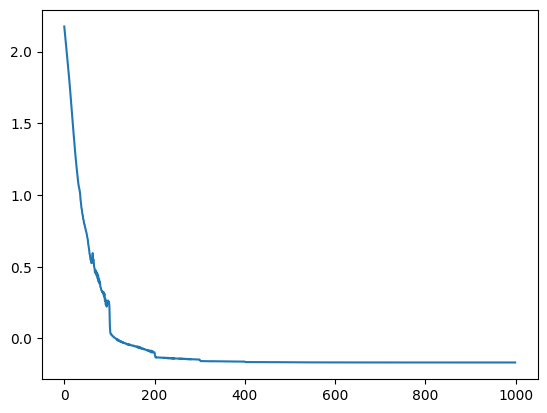

In [67]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

loss_fn(out_1, train_y1.reshape(-1,1))
loss_fn(out_2, train_y2.reshape(-1,1))
loss_fn(out_3, train_y3.reshape(-1,1))

In [68]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.4152e-01, -3.1731e-06, -1.9755e-01, -8.5570e-02, -1.8100e-01,
         -1.8535e-01,  2.1717e-06, -3.7747e-07,  9.0429e-02, -1.8887e-01,
         -8.5185e-02,  2.4924e-06,  1.8322e-07, -2.7001e-06, -1.9375e-06,
         -1.3193e-06,  2.9448e-09, -2.7947e-06, -5.0937e-07,  6.0353e-07,
          9.6662e-07, -4.6399e-07,  6.1463e-07,  2.1903e-06, -1.5495e-06,
          7.7182e-07,  5.0303e-07,  1.2254e-06,  2.4469e-06, -2.9684e-06,
          1.6469e-06, -1.4070e-06, -1.4626e-06,  1.3931e-07,  6.3272e-07,
         -8.6918e-04, -4.1823e-07, -2.8911e-06,  5.9812e-07,  2.6911e-06,
          3.8473e-07, -1.0477e-06, -2.9283e-06,  1.7367e-06,  1.5708e-06,
          1.6346e-06,  6.8162e-02, -1.6091e-06, -1.9168e-06, -6.7633e-07,
         -2.1131e-06, -2.1919e-06, -1.4867e-06,  2.8046e-06,  1.3114e-06,
          1.0511e-06, -2.0606e-06,  1.6535e-06, -4.4775e-07,  2.9361e-07,
         -2.3184e-06, -3.0363e-06,  1.9055e-06, -1.3418e-06,  1.7889e-06,
          1.0180e-07, -3.6536e-07, -2.

tensor([[-1.4152e-01, -3.1731e-06, -1.9755e-01, -8.5570e-02, -1.8100e-01,
         -1.8535e-01,  2.1717e-06, -3.7747e-07,  9.0429e-02, -1.8887e-01,
         -8.5185e-02,  2.4924e-06,  1.8322e-07, -2.7001e-06, -1.9375e-06,
         -1.3193e-06,  2.9448e-09, -2.7947e-06, -5.0937e-07,  6.0353e-07,
          9.6662e-07, -4.6399e-07,  6.1463e-07,  2.1903e-06, -1.5495e-06,
          7.7182e-07,  5.0303e-07,  1.2254e-06,  2.4469e-06, -2.9684e-06,
          1.6469e-06, -1.4070e-06, -1.4626e-06,  1.3931e-07,  6.3272e-07,
         -8.6918e-04, -4.1823e-07, -2.8911e-06,  5.9812e-07,  2.6911e-06,
          3.8473e-07, -1.0477e-06, -2.9283e-06,  1.7367e-06,  1.5708e-06,
          1.6346e-06,  6.8162e-02, -1.6091e-06, -1.9168e-06, -6.7633e-07,
         -2.1131e-06, -2.1919e-06, -1.4867e-06,  2.8046e-06,  1.3114e-06,
          1.0511e-06, -2.0606e-06,  1.6535e-06, -4.4775e-07,  2.9361e-07,
         -2.3184e-06, -3.0363e-06,  1.9055e-06, -1.3418e-06,  1.7889e-06,
          1.0180e-07, -3.6536e-07, -2.

tensor([[-1.8170e-01,  5.5883e-07, -2.5258e-01, -1.8163e-01,  1.9970e-01,
         -2.3980e-01,  5.8792e-07, -1.7929e-06, -1.2918e-01, -2.4164e-01,
         -8.4726e-02, -8.9155e-09, -1.2837e-07,  7.8014e-07, -1.0010e-07,
         -6.6362e-07,  8.6804e-07,  3.5149e-07,  1.1566e-07, -1.0001e-07,
         -1.0340e-08,  2.1863e-07, -7.9900e-08,  7.4612e-08,  4.6358e-07,
          3.7305e-07, -3.5099e-09,  1.8849e-07, -1.1940e-08,  4.8985e-07,
         -8.3643e-07, -6.5642e-07,  9.3412e-07, -5.9167e-08,  2.7628e-07,
         -4.3210e-02,  2.2290e-07,  4.4578e-07,  2.7541e-08, -4.1060e-08,
          7.8059e-08,  1.2172e-07, -1.6128e-07,  5.9162e-08,  9.6692e-07,
         -6.9292e-07,  9.8852e-02,  3.4111e-07,  1.1162e-08,  3.4121e-07,
          2.1219e-07, -5.7496e-08, -1.9790e-08,  2.0311e-08,  3.0370e-07,
          1.0753e-06, -6.8223e-08,  1.0271e-06, -9.9505e-07, -7.7643e-08,
         -1.0495e-08,  1.2107e-07, -5.9461e-07, -1.7861e-07,  2.9299e-09,
         -3.1142e-07,  3.7858e-08, -5.

In [69]:

model_1(test_x1)[0].squeeze()
test_y1.squeeze()
model_2(test_x2)[0].squeeze()
test_y2.squeeze()
model_3(test_x3)[0].squeeze()
test_y3.squeeze()


tensor([0.9496, 0.2993, 0.8483, 0.0216, 0.0061, 0.0045, 0.1768, 0.9855, 0.7805,
        0.0018, 0.0017, 0.8326, 0.9698, 0.0192, 0.9754, 0.6913, 0.0170, 0.0025,
        0.7631, 0.0805, 0.0078, 0.6337, 0.8664, 0.0093, 0.9700, 0.0582, 0.0321,
        0.0045, 0.0014, 0.0030, 0.0467, 0.9709, 0.0073, 0.0385, 0.1770, 0.3168,
        0.6699, 0.2623, 0.8888, 0.0182], grad_fn=<SqueezeBackward0>)

tensor([1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
        0., 1., 1., 0.])

tensor([7.6505e-01, 9.6495e-01, 7.2991e-01, 1.5873e-02, 9.4209e-01, 7.2475e-01,
        3.0840e-02, 8.4358e-01, 1.7688e-01, 6.0509e-05, 5.0117e-01, 9.8523e-01,
        1.6764e-01, 1.5459e-01, 6.1011e-01, 9.9972e-01, 7.9307e-02, 2.3891e-01,
        1.1674e-01, 9.9221e-01, 9.9012e-01, 9.3950e-02, 9.0251e-01, 6.1174e-01,
        3.4185e-03, 5.3503e-02, 9.9931e-01, 9.8452e-01, 1.0111e-02, 7.4127e-01,
        9.8668e-01, 9.8687e-01, 9.9999e-01, 7.1626e-02, 9.7469e-01, 8.2884e-02,
        9.8410e-01, 1.8828e-02, 9.8470e-01, 9.9605e-01],
       grad_fn=<SqueezeBackward0>)

tensor([0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
        0., 1., 1., 1.])

tensor([0.0054, 0.8963, 0.0574, 0.9772, 0.7600, 0.7964, 0.2170, 0.4740, 0.4682,
        0.0106, 0.0656, 0.7455, 0.9826, 0.4078, 0.0500, 0.9926, 0.6120, 0.9100,
        0.5829, 0.0811, 0.8949, 0.0194, 0.2112, 0.9737, 0.3273, 0.0027, 0.0683,
        0.9081, 0.2043, 0.1940, 0.6261, 0.7331, 0.9646, 0.4808, 0.7920, 0.6621,
        0.0527, 0.7762, 0.9748, 0.4436], grad_fn=<SqueezeBackward0>)

tensor([0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
        1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
        0., 1., 1., 1.])

In [70]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[52, 10],
       [ 9, 49]])

0.8448275862068966

0.8387096774193549

0.8416666666666667

0.8305084745762712

0.8376068376068375

In [71]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[22,  2],
       [ 3, 13]])

0.8125

0.9166666666666666

array([[12,  7],
       [ 4, 17]])

0.8095238095238095

0.631578947368421

array([[18,  1],
       [ 2, 19]])

0.9047619047619048

0.9473684210526315

In [72]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_2_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_3_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.4151600e-01, -3.1730533e-06, -1.9755352e-01, -8.5569531e-02,
        -1.8100296e-01, -1.8534961e-01,  2.1716924e-06, -3.7746841e-07,
         9.0428784e-02, -1.8887037e-01, -8.5184827e-02,  2.4923515e-06,
         1.8322315e-07, -2.7000528e-06, -1.9374872e-06, -1.3192562e-06,
         2.9448284e-09, -2.7946683e-06, -5.0937439e-07,  6.0352676e-07,
         9.6661574e-07, -4.6398546e-07,  6.1462850e-07,  2.1902788e-06,
        -1.5495285e-06,  7.7182119e-07,  5.0302867e-07,  1.2253806e-06,
         2.4469437e-06, -2.9684345e-06,  1.6469386e-06, -1.4070025e-06,
        -1.4625738e-06,  1.3930804e-07,  6.3271949e-07, -8.6917874e-04,
        -4.1822526e-07, -2.8910738e-06,  5.9812027e-07,  2.6910591e-06,
         3.8473419e-07, -1.0476965e-06, -2.9282578e-06,  1.7366752e-06,
         1.5708226e-06,  1.6345590e-06,  6.8161562e-02, -1.6091358e-06,
        -1.9168010e-06, -6.7633130e-07, -2.1130552e-06, -2.1919302e-06,
        -1.4867077e-06,  2.8046147e-06,  1.3113601e-06,  1.05111

array([[-1.4151600e-01, -3.1730533e-06, -1.9755352e-01, -8.5569531e-02,
        -1.8100296e-01, -1.8534961e-01,  2.1716924e-06, -3.7746841e-07,
         9.0428784e-02, -1.8887037e-01, -8.5184827e-02,  2.4923515e-06,
         1.8322315e-07, -2.7000528e-06, -1.9374872e-06, -1.3192562e-06,
         2.9448284e-09, -2.7946683e-06, -5.0937439e-07,  6.0352676e-07,
         9.6661574e-07, -4.6398546e-07,  6.1462850e-07,  2.1902788e-06,
        -1.5495285e-06,  7.7182119e-07,  5.0302867e-07,  1.2253806e-06,
         2.4469437e-06, -2.9684345e-06,  1.6469386e-06, -1.4070025e-06,
        -1.4625738e-06,  1.3930804e-07,  6.3271949e-07, -8.6917874e-04,
        -4.1822526e-07, -2.8910738e-06,  5.9812027e-07,  2.6910591e-06,
         3.8473419e-07, -1.0476965e-06, -2.9282578e-06,  1.7366752e-06,
         1.5708226e-06,  1.6345590e-06,  6.8161562e-02, -1.6091358e-06,
        -1.9168010e-06, -6.7633130e-07, -2.1130552e-06, -2.1919302e-06,
        -1.4867077e-06,  2.8046147e-06,  1.3113601e-06,  1.05111

array([[-1.81697667e-01,  5.58832198e-07, -2.52580851e-01,
        -1.81631640e-01,  1.99703619e-01, -2.39802271e-01,
         5.87924774e-07, -1.79285962e-06, -1.29177943e-01,
        -2.41638094e-01, -8.47263634e-02, -8.91545504e-09,
        -1.28365926e-07,  7.80139942e-07, -1.00102184e-07,
        -6.63615822e-07,  8.68035443e-07,  3.51493640e-07,
         1.15656022e-07, -1.00005622e-07, -1.03399689e-08,
         2.18626866e-07, -7.98995501e-08,  7.46120890e-08,
         4.63581102e-07,  3.73051876e-07, -3.50987395e-09,
         1.88492535e-07, -1.19395738e-08,  4.89845604e-07,
        -8.36426921e-07, -6.56420696e-07,  9.34118418e-07,
        -5.91669043e-08,  2.76283288e-07, -4.32095788e-02,
         2.22901406e-07,  4.45781239e-07,  2.75406169e-08,
        -4.10603143e-08,  7.80589531e-08,  1.21715004e-07,
        -1.61280525e-07,  5.91616178e-08,  9.66916673e-07,
        -6.92922697e-07,  9.88519862e-02,  3.41113605e-07,
         1.11620864e-08,  3.41206203e-07,  2.12189789e-0

In [21]:
threshold=0.12
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.14521633,  0.        , -0.21916537, -0.03903408, -0.16219096,
        -0.21445437,  0.        ,  0.        ,  0.10050797, -0.23026493,
        -0.09034549,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.07345747,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  3,  4,  5,  6,  9, 10, 11, 47])

9

(raylet) [2022-11-13 15:50:45,731 E 30389 30414] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_15-42-23_213991_30261 is over 95% full, available space: 513781760; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 15:50:55,740 E 30389 30414] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_15-42-23_213991_30261 is over 95% full, available space: 513769472; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 15:51:05,750 E 30389 30414] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_15-42-23_213991_30261 is over 95% full, available space: 513765376; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-13 15:51:15,760 E 30389 30414] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-13_15-42-23_213991_30261 is over 95% full, available space: 513728512; capacity: 29394726912. Object creation will fail i